<a href="https://colab.research.google.com/github/caribou68/MCMPC_CartPole/blob/main/MCMPC_SingleInvertedPendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup

In [15]:
import math
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
!pip install ffmpeg-python
import ffmpeg
import pandas as pd
import time
matplotlib.interactive(False)
!mkdir -p "/content/MCMPC/images"

In [16]:
def save_log(xs, us, path):
  f = open(path, 'wb')
  list_row = [xs, us]
  pickle.dump(list_row, f)

#Single Inverted Pendulum

In [17]:
class CartPole:
  def __init__(self):
    self.Mc = 2.0  #Mass of cart
    self.Mp = 0.2  #Mass of pole
    self.L = 1.0   #Length of pole
    self.G = 9.81  #Acceleration of gravity

  def dynamics(self, x, u):
    mc = self.Mc
    mp = self.Mp
    l = self.L
    ga = self.G
    y = x[0]     # Cart position[m]
    th = x[1]    # Pole angle[rad]
    dy = x[2]    # Cart velocity[m/s]
    dth = x[3]   # Pole angular velocity[rad/s]
    f = u[0]     # Force on cart(control input)
    sinth = math.sin(th)
    costh = math.cos(th)
    ddy = (f-mp*sinth*(l*dth*dth-ga*costh)) / (mc+mp*sinth*sinth)
    # Angular acceleration of pole
    ddth = (f*costh-mp*l*dth*dth*costh*sinth+(mc+mp)*ga*sinth) / (l * (mc+mp*sinth*sinth))
    return dy, dth, ddy, ddth

  def model_plot(self,xs, us, flag=False):
    fig, ax = plt.subplots(figsize=(40.0, 8.0))
    for i in range(len(xs)):
      plt.cla()
      x = xs[i]
      u = us[i]
      ax.plot([x[0], x[0]-self.L*math.sin(x[1])],[0, self.L*math.cos(x[1])], linewidth=5)
      ax.grid()
      ax.set_xlim([-10,10])
      ax.set_ylim([-2,2])

      ax.quiver(-u+x[0], 0, u, 0, color='red', angles='xy', scale_units='xy', scale=1)
      if flag:
        plt.show()
      fig.savefig("/content/MCMPC/images/image" + str(i).zfill(6))

In [18]:
class CalcCost:
  def __init__(self):
    self.x_ref = [0.0, 0.0, 0.0, 0.0]
    #Cost parameters
    self.Q = [2.5, 20.0, 0.01, 0.01]   #State weight
    self.R = [0.01]                     #Input weight
    self.Qf = [2.5, 20.0, 0.01, 0.01]  #Terminal Weight
    self.nx = 4      # Dimension of state
    self.nu = 1      # Dimension of control input
    self.lbx = [-10, -math.inf, -5.0, -10.0]  # Lower bound of state
    self.ubx = [10, math.inf, 5.0, 10.0]  # Upper bound of state
    self.lbu = [-20.0] # Lower bound of input
    self.ubu = [20.0] # Upper bound of input

  # ステージコスト
  def stage_cost(self, x, u):
    l = 0
    for i in range(self.nx):
      if i == 1:
        l += 0.5 * self.Q[i] * (1.0-math.cos(x[i]-self.x_ref[i]))/(1.0+math.cos(x[i]-self.x_ref[i])+1.0e-5)
      else:
        l += 0.5 * self.Q[i] * (x[i]-self.x_ref[i])**2
      if x[i] < self.lbx[i] or self.ubx[i] < x[i]:
        return math.inf
    for i in range(self.nu):
      l += 0.5 * self.R[i] * u[i]**2
      if u[i] < self.lbu[i] or self.ubu[i] < u[i]:
        return math.inf
    return l

  def terminal_cost(self, x):
    l = 0
    for i in range(self.nx):
      if i == 1:
        l += 0.5 * self.Q[i] * (-math.cos(x[i]-self.x_ref[i])+1)
      else:
        l += 0.5 * self.Q[i] * (x[i]-self.x_ref[i])**2
      if x[i] < self.lbx[i] or self.ubx[i] < x[i]:
        return math.inf
    return l

In [19]:
class MCMPC:
  def __init__(self):
    # Prablem parameters
    self.T = 1.0     # Length of horizon % edit
    self.N = 100   # Horizon discretization grid number %editt
    self.dt = self.T /self.N  # Discretization steps11
    self.nx = 4      # Dimension of state
    self.nu = 1      # Dimension of control input
    self.iteration_num = 4 # Number of iteration
    self.sample_num = 1000 #5000 Number of samples
    self.elite_rate = 0.05
    self.elite_num = int(self.sample_num*self.elite_rate) # Number of samples
    if self.elite_num < 1:
      self.elite_num = 1

    #Nonlinear Programming Problem fomulation
    self.w = [0.0] * self.N    # Optimized variable
    self.w0 = []   # Initial guess solution
    self.lbw = []  # Lower bound of w
    self.ubw = []  # Upper bound of w
    self.g = []    # Constraints
    self.lbg = []  # Lower bound of g
    self.ubg = []  # Upper bound of g
    self.J = 0     # Evaluation function

    self.calc_cost = CalcCost()
    self.cart_pole = CartPole()

  def solve(self, x):
    rng = np.random.default_rng()
    for itr in range(self.iteration_num):
      score_table = pd.DataFrame(data = {'score':[1.0e8]*self.elite_num, 'input':[self.w]*self.elite_num})
      for sample in range(self.sample_num):
        cost = 0.0
        u = []
        x_tmp = x
        for i in range(self.N-1):
          u_tmp = [rng.normal(self.w[i+1], 1.0)]
          u += u_tmp
          x1 = x_tmp + self.dt * np.array(self.cart_pole.dynamics(x_tmp, u_tmp))
          cost += self.calc_cost.stage_cost(x1, u_tmp)
          x_tmp = x1
        u_tmp = [rng.normal(self.w[self.N-1], 1.0)]
        u += u_tmp
        x1 = x_tmp + self.dt * np.array(self.cart_pole.dynamics(x_tmp, u_tmp))
        cost += self.calc_cost.terminal_cost(x1)
        if(cost < score_table.iloc[-1]['score']):
          score_table.iloc[-1] = pd.DataFrame(data = {'score':cost, 'input':[np.array(u)]})
          score_table = score_table.sort_values(by='score')
      cost_sum = score_table['score'].sum()
      nominator=0.0
      denominator=0.0
      for i in range(self.elite_num):
        nominator += math.exp(-score_table.iloc[i]['score']/cost_sum)*score_table.iloc[i]['input'][0]
        denominator += math.exp(-score_table.iloc[i]['score']/cost_sum)
      self.w = (nominator)/(denominator)
    return self.w[0]

In [20]:
def image_plot(xs, us, flag=False):
  fig, ax = plt.subplots(figsize=(40.0, 8.0))
  for i in range(len(xs)):
    plt.cla()
    x = xs[i]
    u = us[i]
    ax.plot([x[0], x[0]-1.0*math.sin(x[1])],[0, 1.0*math.cos(x[1])])
    ax.grid()
    ax.set_xlim([-10,10])
    ax.set_ylim([-2,2])

    ax.quiver(-u+x[0], 0, u, 0, color='red', angles='xy', scale_units='xy', scale=1)
    if flag:
      plt.show()
    fig.savefig("/content/MCMPC/images/image" + str(i).zfill(6))

In [21]:
# Plot solution
def graph_plot(xs, us, sampling_time):
  x1_opt = [x[0] for x in xs]
  x2_opt = [math.atan2(math.sin(x[1]), math.cos(x[1])) for x in xs]
  x3_opt = [x[2] for x in xs]
  x4_opt = [x[3] for x in xs]
  u_opt  = [u for u in us]

  tgrid = [sampling_time*k for k in range(len(xs))]
  plt.figure(1)
  plt.clf()
  plt.step(tgrid, u_opt, '-.')
  plt.plot(tgrid, x1_opt, '--')
  plt.plot(tgrid, x2_opt, '-')
  plt.plot(tgrid, x3_opt, '-')
  plt.plot(tgrid, x4_opt, '-')
  plt.xlabel('t')
  plt.legend(['u','y(x1)','th1(x2)', 'dy(x3)','dth1(x4)'])
  plt.grid()
  plt.show()

In [22]:
sim_time = 15.0
sampling_time = 0.01
sim_steps = math.floor(sim_time/sampling_time)
xs = []
us = []

  0%|          | 0/1502 [00:00<?, ?it/s]

0steps


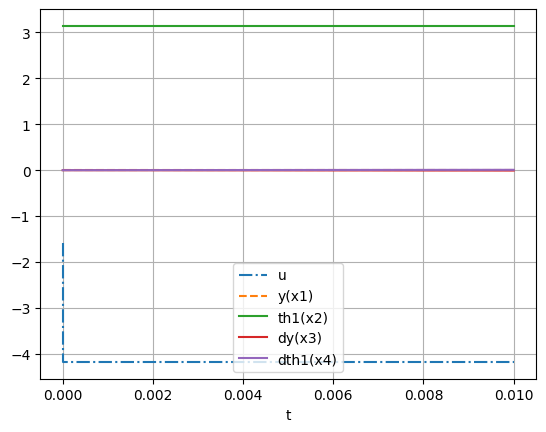

100steps


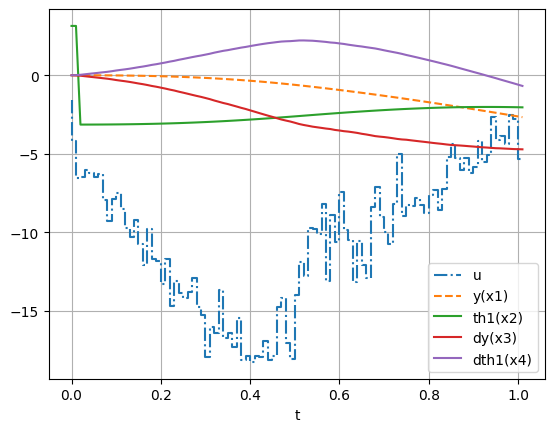

200steps


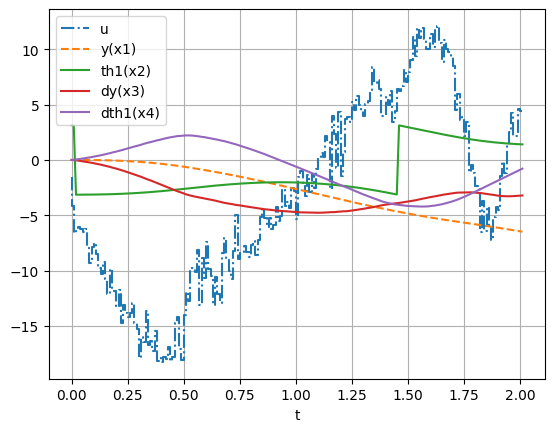

300steps


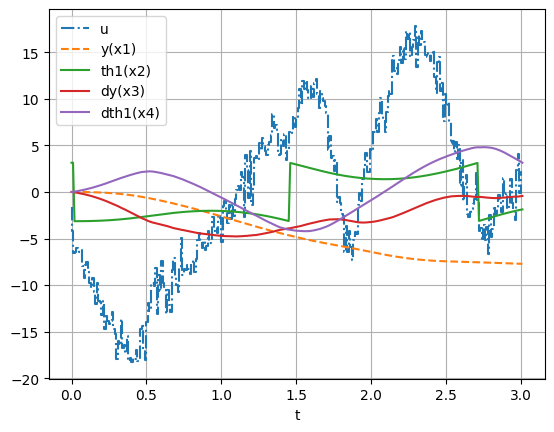

400steps


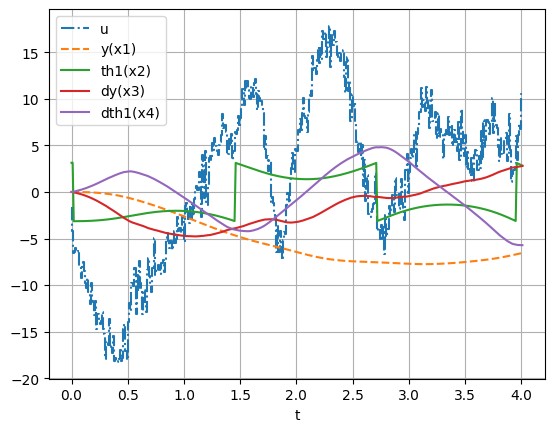

500steps


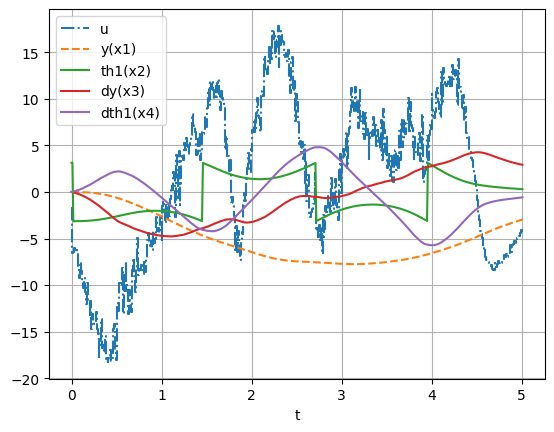

600steps


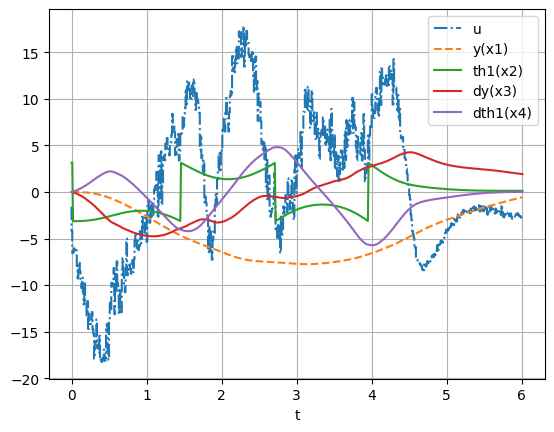

700steps


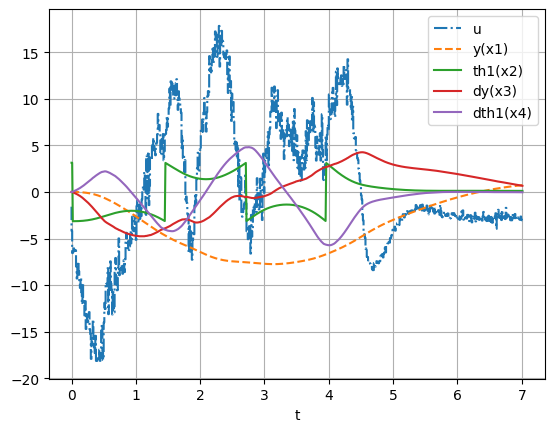

800steps


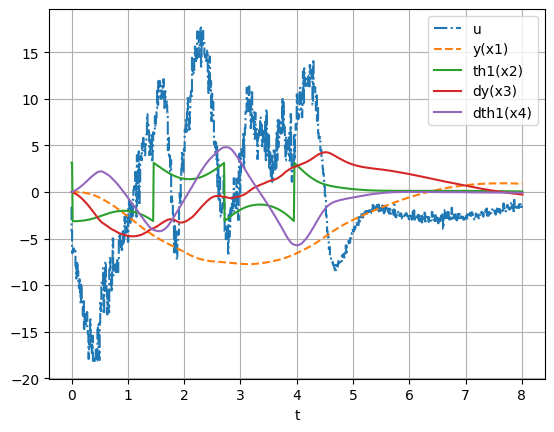

900steps


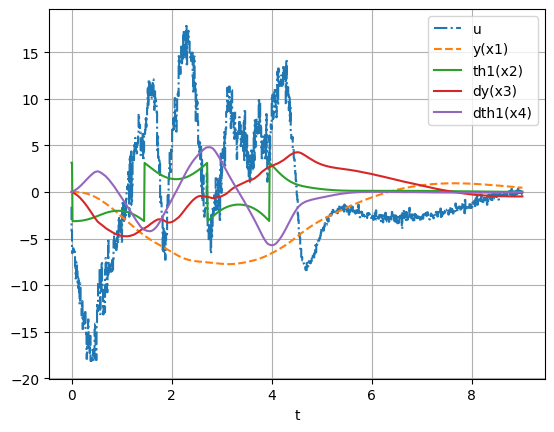

1000steps


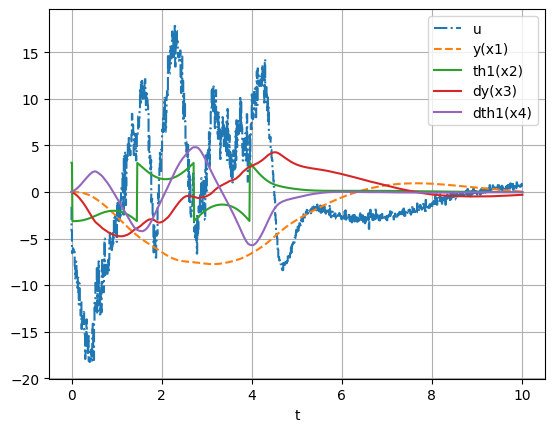

1100steps


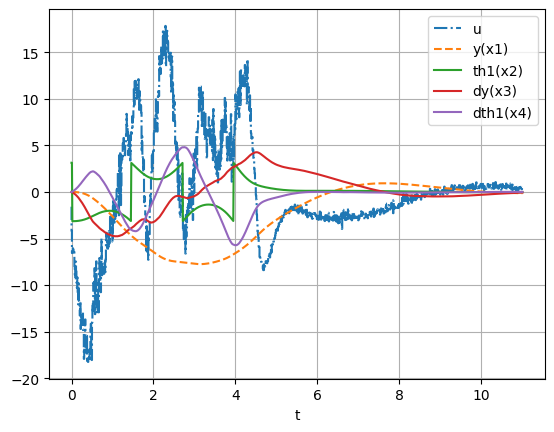

1200steps


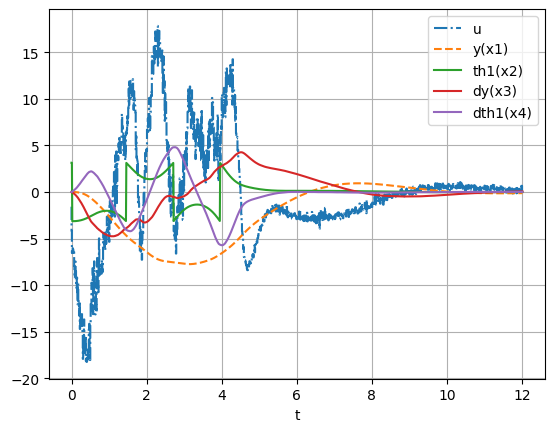

1300steps


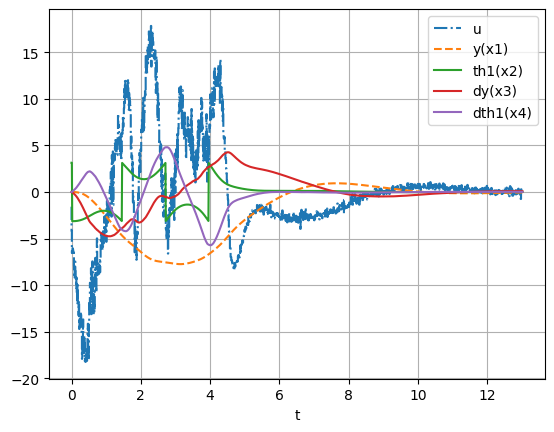

1400steps


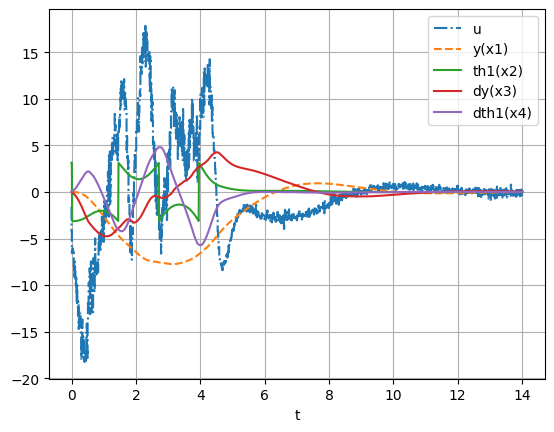

1500steps


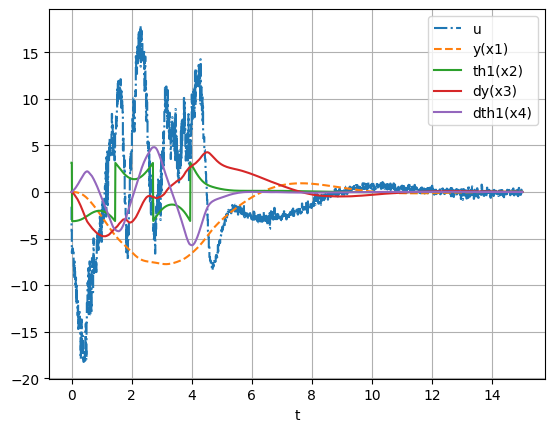

In [23]:
x = np.zeros(4)#Initial state
x[1] = math.pi
cart_pole = CartPole()
mpc = MCMPC()
rng = np.random.default_rng()
log_path = '/content/MCMPC/log.txt'
is_file = os.path.isfile(log_path)
for i in tqdm(range(len(xs)-1, sim_steps+1)):
  u = mpc.solve(x)
  xs.append(x)
  us.append(u)
  x1 = x + sampling_time * np.array(cart_pole.dynamics(x, [u]))
  x = x1
  if i%100 == 0:
    print(str(i)+"steps")
    save_log(xs, us, log_path)
    graph_plot(xs, us[0:len(xs)], sampling_time)

In [24]:
f = open('/content/MCMPC/log.txt',"rb")
list_row = pickle.load(f)
xs = list_row[0]
us = list_row[1]

In [25]:
cart_pole = CartPole()
cart_pole.model_plot(xs, us)

In [ ]:
!ffmpeg -framerate 100 -i '/content/MCMPC/images/image%06d.png' '/content/MCMPC/images/out.mp4' -y

In [ ]:
from IPython.display import HTML
import base64
import io

def play(file_path):
    video = io.open(file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="640" height="480" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('/content/MCMPC/images/out.mp4')

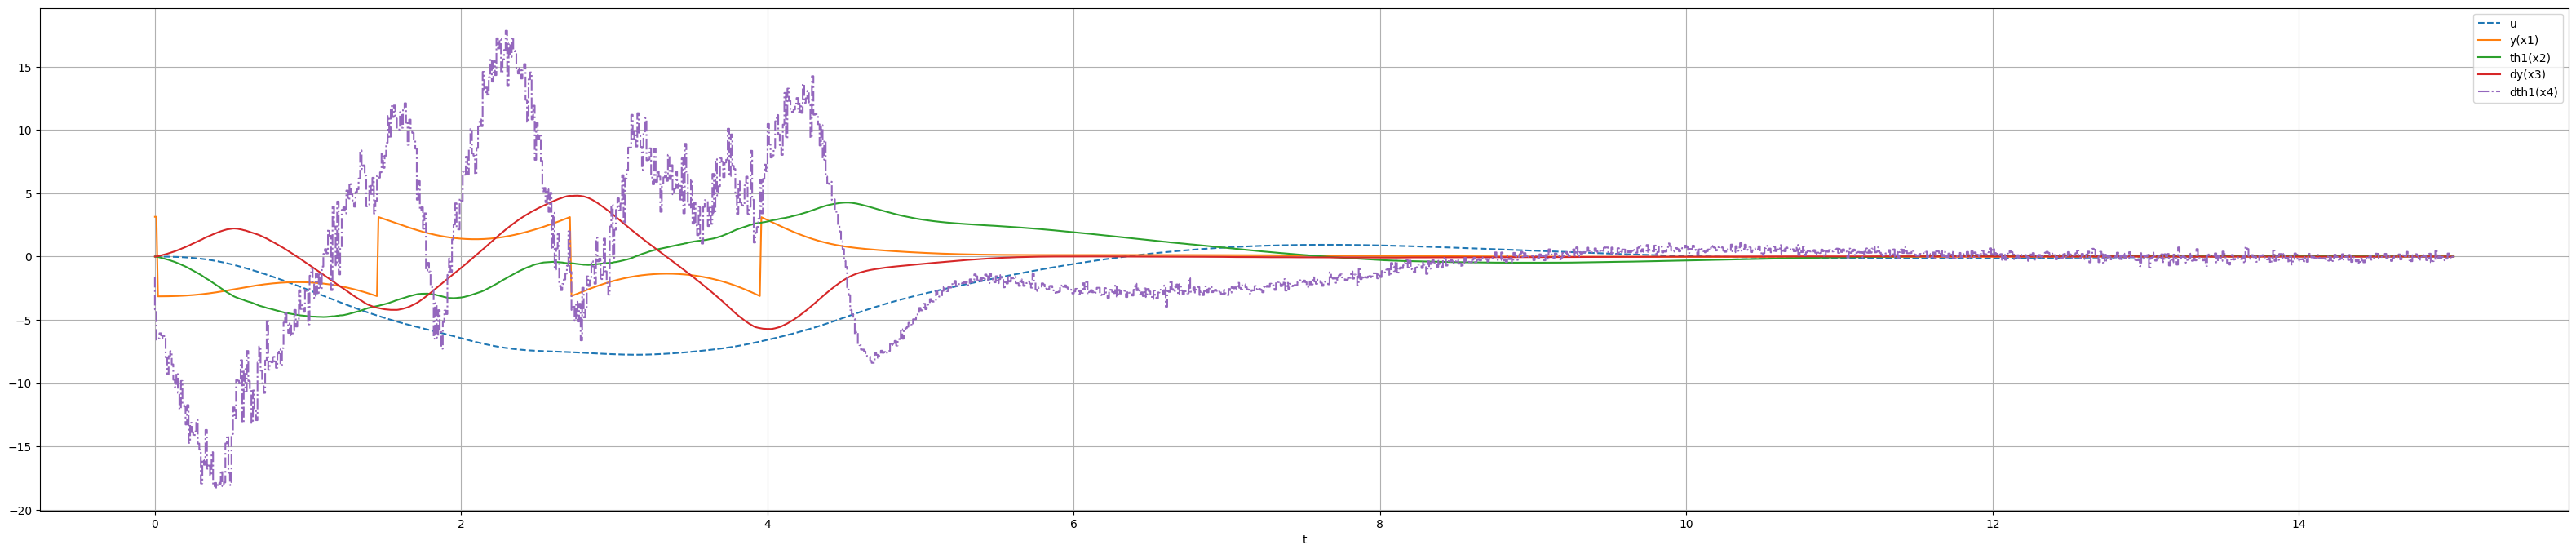

In [28]:
# plot solution
x1_opt = [x[0] for x in xs]
x2_opt = [math.atan2(math.sin(x[1]), math.cos(x[1])) for x in xs]
x3_opt = [x[2] for x in xs]
x4_opt = [x[3] for x in xs]
u_opt  = [u for u in us]

tgrid = [sampling_time*k for k in range(len(xs))]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.plot(tgrid, x3_opt, '-')
plt.plot(tgrid, x4_opt, '-')
plt.step(tgrid, u_opt, '-.')
plt.xlabel('t')
plt.legend(['u','y(x1)','th1(x2)', 'dy(x3)','dth1(x4)'])
plt.grid()
plt.show()